# Import

In [1]:
from interpret import *
from tint.metrics import mse, mae
import tint, captum, gc
from tqdm import tqdm
import pandas as pd
from utils.explainer import *
from exp.exp_interpret import *
from utils.tools import normalize_scale

import matplotlib.pyplot as plt
from utils.plot_config import *
%matplotlib inline

# Util

In [7]:
from data.uea import collate_fn

def prepare_input(
    data, device, args
):
    if args.task_name == 'classification':
        batch_x, batch_y, padding_mask = data
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = data
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

def prepare_from_dataset(data, device, args):
    if args.task_name == 'classification':
        # already converted to tensor from numpy
        batch_x, batch_y, padding_mask = collate_fn(data)
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = [
            torch.stack(
                [
                    torch.tensor(d[i], dtype=float, device=device) 
                    for d in data
                ]
            ) 
            for i in range(4)
        ]
        batch_x = torch.tensor(batch_x).float().to(device)
        batch_y = torch.tensor(batch_y).float().to(device)

        batch_x_mark = torch.tensor(batch_x_mark).float().to(device)
        batch_y_mark = torch.tensor(batch_y_mark).float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

# Arguments

In [2]:
parser = get_parser()

# argv = """
#   --explainers integrated_gradients \
#   --task_name classification \
#   --data mimic \
#   --itr_no 1 \
#   --root_path ./dataset/mimic_iii/ \
#   --data_path mimic_iii.pkl \
#   --metrics auc accuracy cross_entropy \
#   --model Crossformer --n_features 31
# """.split()

# --explainers feature_ablation occlusion augmented_occlusion winIT tsr wtsr \

argv = """
  --task_name long_term_forecast \
  --explainers integrated_gradients \
  --root_path ./dataset/traffic/ \
  --data_path traffic.csv \
  --model Crossformer \
  --itr_no 1 \
  --features S \
  --seq_len 96 \
  --label_len 12 \
  --pred_len 24 \
  --n_features 1
""".split()

args = parser.parse_args(argv)

# only evaluate on test
args.flag = 'test'
# Disable cudnn if using cuda accelerator.
# Please see https://captum.ai/docs/faq#how-can-i-resolve-cudnn-rnn-backward-error-for-rnn-or-lstm-network
# args.use_gpu = False
initial_setup(args)

# Initialize

## Experiment

In [3]:
if args.task_name == 'classification': Exp = Exp_Classification
else: Exp = Exp_Long_Term_Forecast
exp = Exp(args)  # set experiments

# should be test or validation data
dataset, dataloader = exp._get_data(args.flag)
exp.load_best_model()

model = exp.model
_ = model.eval()
# model.zero_grad()

Use GPU: cuda:0
Experiments will be saved in ./results\traffic_Crossformer\1
test 1731
Loading model from ./results\traffic_Crossformer\1\checkpoint.pth


In [4]:
example_no = 0
if args.data_path == 'mimic_iii.pkl':
    first_dead_patient = 0
    while True:
        if first_dead_patient >= len(dataset): break
        if dataset[first_dead_patient][1].item() == 1: break
        first_dead_patient += 1
        
    if first_dead_patient>= len(dataset):
        raise Exception(f'No dead patient in {args.flag}')
    else:
        print(f'First dead patient: {first_dead_patient}')
    example_no = first_dead_patient
else:
    example_no = np.random.randint(0, len(dataset)-1)
    print(f'Randomly chosen {example_no}')

Randomly chosen 1672


## Explainer

In [5]:
from exp.exp_interpret import Exp_Interpret

explainers_map = dict() 
for name in exp.args.explainers:
    explainer = Exp_Interpret.initialize_explainer(
        name, exp.model, exp.args, exp.device, dataloader
    ) 
    explainers_map[name] = explainer

# Batch Evaluate

In [ ]:
# results = []

# result_columns = ['batch_index', 'explainer', 'metric', 'area', 'comp', 'suff']

# progress_bar = tqdm(
#     enumerate(dataloader), total=len(dataloader), disable=False
# )

# for batch_index, data in progress_bar:
#     # get inputs
#     inputs, additional_forward_args, _ = prepare_input(
#         data, exp.device, args
#     )
        
#     # baseline must be a scaler or tuple of tensors with same dimension as input
#     baselines = get_baseline(inputs, args.baseline_mode)
    
#     # interpret
#     for name in args.explainers:
#         explainer = explainers_map[name]
        
#         # get attributions
#         if args.task_name == 'classification':
#             attr = compute_attr(
#                 inputs, baselines, explainer, 
#                 additional_forward_args, args
#             )
#         else:
#             attr = compute_attr(
#                 inputs, baselines, explainer, 
#                 additional_forward_args, args
#             )
    
#         # evaluate
#         for area in args.areas:
#             for metric_name in args.metrics:
#                 metric = expl_metric_map[metric_name]
#                 error_comp = metric(
#                     model, inputs=inputs, 
#                     attributions=attr, baselines=baselines, 
#                     additional_forward_args=additional_forward_args,
#                     topk=area, mask_largest=True
#                 )
                
#                 error_suff = metric(
#                     model, inputs=inputs, 
#                     attributions=attr, baselines=baselines, 
#                     additional_forward_args=additional_forward_args,
#                     topk=area, mask_largest=False
#                 )
           
#                 result_row = [batch_index, name, metric_name, area, error_comp, error_suff]
#                 # print(result_row)
#                 results.append(result_row)

In [ ]:
# results_df = pd.DataFrame(results, columns=result_columns)
# results_df = results_df.groupby(
#     ['explainer', 'metric', 'area']
# )[['comp', 'suff']].aggregate('mean').reset_index()

# # results_df.round(6).to_csv(os.path.join(result_folder, 'interpretation_results.csv'), index=False)
# print(results_df)

# Single Evaluate

## Input

In [8]:
# inputs, additional_forward_args, labels = prepare_input(
#     next(iter(dataloader)), exp.device, args
# )
if args.task_name == 'classification':
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[example_no]], exp.device, args
    )
else: 
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[example_no]], exp.device, args
    )
baselines = get_baseline(inputs, args.baseline_mode)

## Explainer

In [37]:
def wrapper(*args, **kwargs):
    outputs = model(*args, **kwargs)
    outputs = torch.squeeze(outputs, dim=-1)
    return outputs

outputs = wrapper(*inputs, *additional_forward_args)

In [49]:
# inputs[0].requires_grad = True
# inputs[1].requires_grad = True
# additional_forward_args[0].requires_grad = True
# additional_forward_args[1].requires_grad = True
# for a in inputs + additional_forward_args:
#     print(a.requires_grad)

In [57]:
explainer = IntegratedGradients(wrapper)
attr = explainer.attribute(
    inputs=inputs, baselines=baselines, target=0,
    additional_forward_args=additional_forward_args
)

In [56]:
# explainer = FeatureAblation(model)
# explainer = explainers_map[name]
attr_map = dict()

for name in exp.args.explainers:
    print(name)
    explainer = explainers_map[name]
    attr = compute_attr(
        name, inputs, baselines, explainer, 
        additional_forward_args, args
    )
        
    if args.task_name == 'classification':
        attr_normed = normalize_scale(attr, dim=(2, 3), norm_type='minmax')
        attr_numpy = attr.detach().cpu().numpy()
        attr_normed = attr_normed.detach().cpu().numpy()
    else:
        attr_normed = tuple([normalize_scale(a, dim=(2, 3), norm_type='minmax') for a in attr])
        attr_numpy = tuple([a.detach().cpu().numpy() for a in attr])
        attr_normed = tuple([a.detach().cpu().numpy() for a in attr_normed])

    attr_map[name] = (attr, attr_normed)

### Visualize

In [20]:
sample_no = 0
samples = 1
target = 1
cmap='binary' # binary, RdYlGn, grey, hot

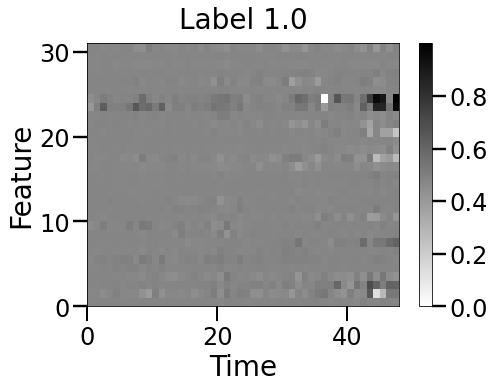

In [21]:
fig, axes = plt.subplots(1, samples, figsize =(min(18, 7*samples), 5.5))

if samples ==1:
    if target is None:
        psm = axes.pcolormesh(
            attr_normed[0].mean(axis=0).T, cmap=cmap, # rasterized=True, # vmin=0, vmax=1
        )
    else:
        psm = axes.pcolormesh(
            attr_normed[0, target].T, cmap=cmap, # rasterized=True, # vmin=0, vmax=1
        )
        
    fig.colorbar(psm, ax=axes)
    axes.set_xlabel('Time')
    axes.set_ylabel('Feature')
    axes.title.set_text(f'Label {labels[0].item()}')
else:
    for sample_no in range(samples):
        if target is None:
            psm = axes[sample_no].pcolormesh(
                attr_normed[sample_no].mean(axis=0).T, cmap=cmap, # rasterized=True, # vmin=0, vmax=1
            )
        else:
            psm = axes[sample_no].pcolormesh(
                attr_normed[sample_no, target].T, cmap=cmap, # rasterized=True, # vmin=0, vmax=1
            )
        fig.colorbar(psm, ax=axes[sample_no])
        axes[sample_no].set_xlabel('Time')
        axes[sample_no].set_ylabel('Feature')
        axes[sample_no].title.set_text(f'Sample {sample_no+1}, Label {labels[sample_no].item()}')

fig.tight_layout()
plt.show()

### Evaluate

In [ ]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=attr[:, target], baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=attr[:, target], baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')

# Visualization

In [ ]:
sample_no = 0
target = 1
cmap='binary' # binary, RdYlGn, grey, hot

## Single feature

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# feature_no = 0

# if type(attr_normed) == tuple:
#     attr_normed = attr_normed[0]
    
# axes[0].plot(attr_normed[sample_no, target, :, feature_no], label='FA')
# axes[0].legend()
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('Feature importance')

# axes[1].plot(tsr_attr_normed[sample_no, target, :, feature_no], label='WTSR + FA')
# axes[1].legend()
# axes[1].set_xlabel('Time')
    
# fig.tight_layout()
# # plt.savefig('results/single_example.jpg', dpi=200)
# plt.show()

## All features

In [ ]:
n = len(args.explainers)
rows, columns = 1, n
width_ratios=  [1] * (n-1) + [1.1]

if args.data_path == 'mimic_iii.pkl':
    fig, axes = plt.subplots(rows, columns, figsize =(36, 4), width_ratios=width_ratios)
else:
    fig, axes = plt.subplots(rows, columns, figsize =(32, 4))

for row in range(rows):
    for col in range(columns):
        feature_no = row * 2 + col
        name = args.explainers[feature_no]
        attr_normed = attr_map[name][1]
        if type(attr_normed) == tuple:
            # concatenate across feature dimension
            # attr_normed = np.concatenate(attr_normed, axis=-1)
            
            # only use the encoder features
            attr_normed = attr_normed[0]
            
        # attr_normed = np.mean(attr_normed, axis=1)
        if rows == 1: ax = axes[col]
        else: ax = axes[row][col]
            
        # if only one feature
        if attr_normed.shape[-1] == 1:
            if target is None:
                ax.plot(attr_normed[sample_no].mean(axis=0).T[0])
            else:    
                ax.plot(attr_normed[sample_no, target].T[0])
        else:
            if target is None:
                psm = ax.pcolormesh(
                    attr_normed[sample_no].mean(axis=0).T, 
                    cmap=cmap, vmax=1 # rasterized=True
                )
            else:
                psm = ax.pcolormesh(
                    attr_normed[sample_no, target].T, 
                    cmap=cmap, vmax=1 # rasterized=True
                )
            # colorbar at the rightmost column
            if col + 1 == columns:
                fig.colorbar(psm, ax=ax)
        
        
        # make the axes more visible
        plt.setp(ax.spines.values(), linewidth=2) 
        if col > 0:
            ax.get_yaxis().set_visible(False)   
        
        # im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
        # axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
        # name = explainer_name_map[]
        if name == 'winIT': name = 'WinIT'
        else:
            name = explainer_name_map[name].get_name()
        ax.set_title(name)
        if args.data_path == 'mimic_iii.pkl':
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
            ax.yaxis.set_major_locator(MultipleLocator(base=10))
        else:
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
        # ax.set_ylabel('Feature')

fig.tight_layout()
fig.supylabel('Feature', fontsize=36, x=-.015)
fig.supxlabel('Time', fontsize=36, y=-0.12)
# plt.suptitle('Heat map of feature importance scores')
plt.savefig(f'{exp.output_folder}/heatmap.jpg', dpi=200, bbox_inches="tight")
plt.show()

# WIP

## Density plot

In [ ]:
# import scipy.stats as st
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# n_bins = 128

# dist1 = attr_normed[:, target, :, feature_no].flatten()
# dist2 = tsr_attr_normed[:, target, :, feature_no].flatten()

# _ = axes[0].hist(dist1, bins=n_bins, density=True)
# # We can set the number of bins with the *bins* keyword argument.
# kde = st.gaussian_kde(dist1)
# mn, mx = axes[0].get_xlim()
# kde_xs = np.linspace(mn, mx, 100)
# axes[0].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
# axes[0].set_ylabel('Count')
# axes[0].set_xlabel(f'{explainer.get_name()}')
# axes[0].set_xlim(-0.1, 1)

# _ = axes[1].hist(dist2, bins=n_bins, density=True)
# axes[1].set_xlabel(f'WTSR + {explainer.get_name()}')
# kde = st.gaussian_kde(dist2)
# mn, mx = axes[1].get_xlim()
# kde_xs = np.linspace(mn, mx, 100)
# axes[1].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
# axes[1].set_xlim(-0.1, 1)
# # plt.suptitle('Histogram and density plot of feature importance scores')
# fig.tight_layout()
# # plt.savefig('results/density.jpg', dpi=200)

## WinTSR

In [ ]:
from attrs.winTSR import WinTSR
explainer = WinTSR(model, args)

In [ ]:
attr = explainer.attribute(
    inputs, baselines, 
    additional_forward_args, 
    attributions_fn=abs
)

## Visualize

In [ ]:
fig, axes = plt.subplots(1, 2, figsize =(16, 5))

psm = axes[0].pcolormesh(
    attr_normed[example_no, target].T, 
    cmap=cmap, # rasterized=True, # vmin=0, vmax=1
)
fig.colorbar(psm, ax=axes[0])
# im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
# axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Feature')


psm = axes[1].pcolormesh(
    attr[example_no, target].T, 
    cmap=cmap, # rasterized=True, # vmin=0, vmax=1
)
fig.colorbar(psm, ax=axes[1])
axes[1].set_xlabel('Time')

fig.tight_layout()
# plt.suptitle('Heat map of feature importance scores')
# plt.savefig('results/heatmap.jpg', dpi=200)
plt.show()

## Evaluate

In [ ]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=avg_wtsr_attr, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=avg_wtsr_attr, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')